### PROBLEM STATEMENT
**• DOMAIN:** Automotive. Surveillance.<br/>
**• CONTEXT:**<br/>
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is
predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of
the car, type, colour, number plates etc.<br/>
**• DATA DESCRIPTION:**<br/>
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g.
2012 Tesla Model S or 2012 BMW M3 coupe.<br/>
**Data description:**
‣ Train Images: Consists of real images of cars as per the make and year of the car.<br/>
‣ Test Images: Consists of real images of cars as per the make and year of the car.<br/>
‣ Train Annotation: Consists of bounding box region for training images.<br/>
‣ Test Annotation: Consists of bounding box region for testing images.<br/>

#### Milestone 1:

**Step 1: Import the data**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Loading train and test annotation csv files

In [3]:
train_anno_df=pd.read_csv('Annotations 2/Train Annotations.csv')
test_anno_df=pd.read_csv('Annotations 2/Test Annotation.csv')

In [4]:
train_anno_df.rename(columns={'Bounding Box coordinates': 'x0', 'Unnamed: 2': 'y0','Unnamed: 3': 'x1','Unnamed: 4': 'y1'}, inplace=True)
train_anno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image Name   8144 non-null   object
 1   x0           8144 non-null   int64 
 2   y0           8144 non-null   int64 
 3   x1           8144 non-null   int64 
 4   y1           8144 non-null   int64 
 5   Image class  8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [5]:
train_anno_df.head(10)

Image Name   x0   y0    x1    y1  Image class
0  00001.jpg   39  116   569   375           14
1  00002.jpg   36  116   868   587            3
2  00003.jpg   85  109   601   381           91
3  00004.jpg  621  393  1484  1096          134
4  00005.jpg   14   36   133    99          106
5  00006.jpg  259  289   515   416          123
6  00007.jpg   88   80   541   397           89
7  00008.jpg   73   79   591   410           96
8  00009.jpg   20  126  1269   771          167
9  00010.jpg   21  110   623   367           58

In [6]:
test_anno_df.rename(columns={'Bounding Box coordinates': 'x0', 'Unnamed: 2': 'y0','Unnamed: 3': 'x1','Unnamed: 4': 'y1'}, inplace=True)
test_anno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image Name   8041 non-null   object
 1   x0           8041 non-null   int64 
 2   y0           8041 non-null   int64 
 3   x1           8041 non-null   int64 
 4   y1           8041 non-null   int64 
 5   Image class  8041 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 377.0+ KB


In [7]:
test_anno_df.head(10)

Image Name   x0   y0    x1    y1  Image class
0  00001.jpg   30   52   246   147          181
1  00002.jpg  100   19   576   203          103
2  00003.jpg   51  105   968   659          145
3  00004.jpg   67   84   581   407          187
4  00005.jpg  140  151   593   339          185
5  00006.jpg   20   77   420   301           78
6  00007.jpg  249  166  2324  1459          118
7  00008.jpg  119  215  1153   719          165
8  00009.jpg    1    7   275   183           32
9  00010.jpg   28   55   241   177           60

### Step 2: Map training and testing images to its classes.

In [8]:
#Loading name of cars 
carNameDF= pd.read_csv("Car+names+and+make.csv",header=None)

In [9]:
carNameDF.shape

(196, 1)

In [10]:
carNameDF.head(10)

0
0                AM General Hummer SUV 2000
1                       Acura RL Sedan 2012
2                       Acura TL Sedan 2012
3                      Acura TL Type-S 2008
4                      Acura TSX Sedan 2012
5                 Acura Integra Type R 2001
6                  Acura ZDX Hatchback 2012
7  Aston Martin V8 Vantage Convertible 2012
8        Aston Martin V8 Vantage Coupe 2012
9      Aston Martin Virage Convertible 2012

In [11]:
carNameDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       196 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


#### Function to create data frame with Image Name,Image np array,Car Make

In [12]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
CHANNEL=3

In [13]:
import os
import tensorflow
from keras.preprocessing import image
#from tqdm import tqdm
def createImageDF(imageSourceFolder,target_size_tuple,colormode,totalImagePerClassCap):
    dfRows=[]
    for dirname, _, filenames in os.walk(imageSourceFolder):
            limit=0
            if len(filenames) < totalImagePerClassCap or totalImagePerClassCap == 0:
                limit=len(filenames)
            else:
                limit=totalImagePerClassCap
            for i in range(0,limit):
                    processedRows=[]
                    filename=filenames[i]
                    processedRows.append(filename)
                    pathSplits=dirname.split('/')
                    #print(os.path.join(dirname, filename))
                    imgPath=os.path.join(dirname, filename)
                    #print(imgPath)
                    img = image.load_img(imgPath)
                    if target_size_tuple!='':
                        img_scaled = image.load_img(imgPath, target_size=target_size_tuple, color_mode = colormode)
                        image_width_scale_fact=target_size_tuple[0]/img.width
                        image_height_scale_fact=target_size_tuple[1]/img.height
                        imgArray = image.img_to_array(img_scaled)
                    else:
                        img
                        image_width_scale_fact=img.width
                        image_height_scale_fact=img.height
                        #img = Image.open(imgPath)
                        imgArray = image.img_to_array(img)
                    #imgArray=np.asarray(img)
                    processedRows.append(imgArray)
                    processedRows.append(pathSplits[len(pathSplits)-1])
                    processedRows.append(image_width_scale_fact)
                    processedRows.append(image_height_scale_fact)
                    dfRows.append(processedRows)
    return pd.DataFrame(dfRows, columns=["Image Name","image_array","model","image_width_scale_fact","image_height_scale_fact"])


In [14]:
def loadSingleScoringImage(imageSourcePath,target_size_tuple,colormode):
    dfRows=[]
    processedRow=[]
    imgPath=imageSourcePath
    img = image.load_img(imgPath)
    pathSplits=imgPath.split('/')
    if target_size_tuple!='':
        img_scaled = image.load_img(imgPath, target_size=target_size_tuple, color_mode = colormode)
        image_width_scale_fact=target_size_tuple[0]/img.width
        image_height_scale_fact=target_size_tuple[1]/img.height
        imgArray = image.img_to_array(img_scaled)
    else:
        img
        image_width_scale_fact=img.width
        image_height_scale_fact=img.height
        #img = Image.open(imgPath)
        imgArray = image.img_to_array(img)
    #imgArray=np.asarray(img)
    processedRow.append(pathSplits[len(pathSplits)-1])
    processedRow.append(imgArray)
    processedRow.append(pathSplits[len(pathSplits)-2])
    processedRow.append(image_width_scale_fact)
    processedRow.append(image_height_scale_fact)
    dfRows.append(processedRow)
    return pd.DataFrame(dfRows, columns=["Image Name","image_array","model","image_width_scale_fact","image_height_scale_fact"])

In [29]:
trainImageDF=createImageDF('archive/car_data/train','',"rgb",2)

In [30]:
trainImageDF.head(10)

Image Name                                        image_array  \
0  06796.jpg  [[[249.0, 255.0, 241.0], [250.0, 255.0, 249.0]...   
1  04157.jpg  [[[8.0, 7.0, 2.0], [33.0, 32.0, 27.0], [32.0, ...   
2  05704.jpg  [[[77.0, 79.0, 78.0], [43.0, 45.0, 44.0], [96....   
3  01172.jpg  [[[192.0, 213.0, 240.0], [192.0, 213.0, 240.0]...   
4  02136.jpg  [[[247.0, 249.0, 248.0], [247.0, 249.0, 248.0]...   
5  07662.jpg  [[[60.0, 75.0, 118.0], [60.0, 75.0, 118.0], [5...   
6  05103.jpg  [[[60.0, 54.0, 56.0], [60.0, 54.0, 56.0], [61....   
7  03228.jpg  [[[207.0, 198.0, 189.0], [207.0, 198.0, 189.0]...   
8  07852.jpg  [[[100.0, 100.0, 100.0], [100.0, 100.0, 100.0]...   
9  04234.jpg  [[[210.0, 210.0, 210.0], [210.0, 210.0, 210.0]...   

                                        model  image_width_scale_fact  \
0                  Dodge Dakota Crew Cab 2010                     416   
1                  Dodge Dakota Crew Cab 2010                     259   
2                GMC Canyon Extended Cab 2012                     259   
3                GMC Canyon Extended Cab 2012                     480   
4                   Hyundai Santa Fe SUV 2012                     600   
5                   Hyundai Santa Fe SUV 2012                    1024   
6                      Dodge Durango SUV 2012                     640   
7                      Dodge Durango SUV 2012                     625   
8  Chevrolet Silverado 1500 Extended Cab 2012                     960   
9  Chevrolet Silverado 1500 Extended Cab 2012                     480   

   image_height_scale_fact  
0                      312  
1                      194  
2                      194  
3                      360  
4                      338  
5                      768  
6                      425  
7                      468  
8                      720  
9                      360

In [31]:
#Lodaing annotation details for images from train_anno_df i.e. train annotations
trainMergedImageDF=pd.merge(trainImageDF,train_anno_df, on=['Image Name'])

In [32]:
trainMergedImageDF.head(10)

Image Name                                        image_array  \
0  06796.jpg  [[[249.0, 255.0, 241.0], [250.0, 255.0, 249.0]...   
1  04157.jpg  [[[8.0, 7.0, 2.0], [33.0, 32.0, 27.0], [32.0, ...   
2  05704.jpg  [[[77.0, 79.0, 78.0], [43.0, 45.0, 44.0], [96....   
3  01172.jpg  [[[192.0, 213.0, 240.0], [192.0, 213.0, 240.0]...   
4  02136.jpg  [[[247.0, 249.0, 248.0], [247.0, 249.0, 248.0]...   
5  07662.jpg  [[[60.0, 75.0, 118.0], [60.0, 75.0, 118.0], [5...   
6  05103.jpg  [[[60.0, 54.0, 56.0], [60.0, 54.0, 56.0], [61....   
7  03228.jpg  [[[207.0, 198.0, 189.0], [207.0, 198.0, 189.0]...   
8  07852.jpg  [[[100.0, 100.0, 100.0], [100.0, 100.0, 100.0]...   
9  04234.jpg  [[[210.0, 210.0, 210.0], [210.0, 210.0, 210.0]...   

                                        model  image_width_scale_fact  \
0                  Dodge Dakota Crew Cab 2010                     416   
1                  Dodge Dakota Crew Cab 2010                     259   
2                GMC Canyon Extended Cab 2012                     259   
3                GMC Canyon Extended Cab 2012                     480   
4                   Hyundai Santa Fe SUV 2012                     600   
5                   Hyundai Santa Fe SUV 2012                    1024   
6                      Dodge Durango SUV 2012                     640   
7                      Dodge Durango SUV 2012                     625   
8  Chevrolet Silverado 1500 Extended Cab 2012                     960   
9  Chevrolet Silverado 1500 Extended Cab 2012                     480   

   image_height_scale_fact   x0   y0    x1   y1  Image class  
0                      312   57   88   361  293           90  
1                      194   10   20   256  171           90  
2                      194   50   33   229  144          122  
3                      360   50  107   458  299          122  
4                      338  128   33   515  309          131  
5                      768   20   11  1007  717          131  
6                      425   47   35   590  403           94  
7                      468   22    8   607  434           94  
8                      720    1  168   948  503           74  
9                      360    1  103   456  266           74

In [33]:
len(trainMergedImageDF)

392

**Function to create bounding box on image**

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def drowBoxedImages(dataFrame,featureCol,x0,y0,x1,y1,boxlinewidth,boxedgecolor):
  fig,ax=plt.subplots(len(dataFrame))
  fig.set_size_inches(15,15)
  # Display the image
  for index, row in dataFrame.iterrows():
    data=row[featureCol]
    img = image.array_to_img(data)
    ax[index].imshow(img)
    image_height, image_width, _ = data.shape
    rect=[]
    rect.append(patches.Rectangle((row[x0], row[y0]), row[x1] - row[x0], row[y1] - row[y0], linewidth=boxlinewidth, edgecolor=boxedgecolor, facecolor='none'))
    # Add the patch to the Axes
    for l in range(0,len(rect)):
      ax[index].add_patch(rect[l])
  plt.show()

In [35]:
def drowImages(dataFrame,featureCol):
  fig,ax=plt.subplots(len(dataFrame))
  fig.set_size_inches(15,15)
  # Display the image
  for index, row in dataFrame.iterrows():
    data=row[featureCol]
    img = image.array_to_img(data)
    ax[index].imshow(img)
  plt.show()

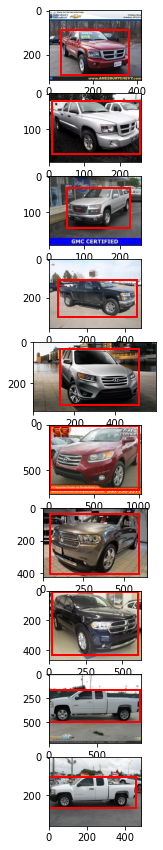

In [36]:
drowBoxedImages(trainMergedImageDF.head(10),'image_array','x0','y0','x1','y1',2,'r')

**For test data**

In [22]:
#testImageDF=createImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test','',"rgb",2)

In [23]:
#testImageDF.head(10)

In [24]:
# Lodaing annotation details for images from train_anno_df i.e. train annotations
#testMergedImageDF=pd.merge(testImageDF,test_anno_df, on=['Image Name'])

In [25]:
#testMergedImageDF.head(10)

In [26]:
#drowBoxedImages(testMergedImageDF.head(10),'image_array','x0','y0','x1','y1',2,'r')

### Let's check distribution of each class in our training data

In [27]:
import seaborn as sns
sns.set_theme(style="darkgrid")
#sns.histplot(x= trainMergedImageDF['Image class'],bins = 20)

### From above histogram it is clear that we have almost equal density distribution among car classes in training data df

### Let's reduce size of training data set images

In [28]:
#trainReducedImageDF=createImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL),"rgb",5)

In [29]:
#trainReducedImageDF.head(5)

In [30]:
#drowImages(trainReducedImageDF.head(5),'image_array')

In [31]:
# Lodaing annotation details for images from train_anno_df i.e. train annotations
#trainReducedMergedImageDF=pd.merge(trainReducedImageDF,train_anno_df, on=['Image Name'])

In [32]:
#trainReducedMergedImageDF.head()

#### Function to create scalled bounding boxes

In [33]:
def scaledBoundingBoxCreator(df):
    df['x0_scaled']=df.x0 *df.image_width_scale_fact
    df['y0_scaled']=df.y0*df.image_height_scale_fact
    df['x1_scaled']=df.x1*df.image_width_scale_fact
    df['y1_scaled']=df.y1*df.image_height_scale_fact
    df['x0_scaled']=df['x0_scaled'].apply(np.floor)
    df['y0_scaled']=df['y0_scaled'].apply(np.floor)
    df['x1_scaled']=df['x1_scaled'].apply(np.floor)
    df['y1_scaled']=df['y1_scaled'].apply(np.floor)

In [34]:
#scaledBoundingBoxCreator(trainReducedMergedImageDF)

In [35]:
#trainReducedMergedImageDF.head()

In [36]:
#drowBoxedImages(trainReducedMergedImageDF.head(),'image_array','x0_scaled','y0_scaled','x1_scaled','y1_scaled',2,'g')

### Noramlizing image features as they are raingeing from 0 to 255

In [37]:
#trainReducedMergedImageDF['image_array']=trainReducedMergedImageDF['image_array']/255

In [38]:
#trainReducedMergedImageDF.head(2)

In [39]:
#drowBoxedImages(trainReducedMergedImageDF.head(),'image_array','x0_scaled','y0_scaled','x1_scaled','y1_scaled',2,'g')

#### Creating reduced image size test data

In [40]:
#testReducedImageDF=createImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test',(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL),"grayscale",5)

In [41]:
# Lodaing annotation details for images from test_anno_df i.e. test annotations
#testReducedMergedImageDF=pd.merge(testReducedImageDF,test_anno_df, on=['Image Name'])

In [42]:
#scaledBoundingBoxCreator(testReducedMergedImageDF)

### Noramlizing image features as they are raingeing from 0 to 255

In [43]:
#testReducedMergedImageDF['image_array']=testReducedMergedImageDF['image_array']/255

### Let's create X_train,y_train,x_test,y_test variables

In [44]:
#testReducedMergedImageDF['image_array'].shape

In [45]:
# Creating an empty tensor to store image arrays
def createFeatureTensor(dfCol,imgWth,imgHit,chnl):
    tensor = np.zeros((dfCol.shape[0],imgWth,imgHit,chnl))
    # Iterating through image arrays to update tensor
    for idx, i in enumerate(dfCol):
        tensor[idx] = i
    # Checking the tensor shape
    tensor.shape
    return tensor

In [46]:
# Creating an empty tensor to store image arrays
def createBondingBoxTensor(df,x0,y0,x1,y1):
    labelBox = []
    # Iterating through image arrays to update tensor
    for i in range(0,len(df[x0])):
        params=[]
        params.append(df[x0][i])
        params.append(df[y0][i])
        params.append(df[x1][i])
        params.append(df[y1][i])
        labelBox.append(params)
    return np.array(labelBox)

In [47]:
#x_train = createFeatureTensor(trainReducedMergedImageDF['image_array'],IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL)
#x_test = createFeatureTensor(testReducedMergedImageDF['image_array'],IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL)

In [48]:
#x_train.shape

In [49]:
from scipy import ndimage as ndi
from skimage import segmentation
from skimage import filters
def createMask(img):
    sobel = filters.sobel(img)
    blurred = filters.gaussian(sobel, sigma=2.0,multichannel=False)
    light_spots = np.array((img > 180).nonzero()).T
    dark_spots = np.array((img < 2).nonzero()).T
    bool_mask = np.zeros(img.shape, dtype=np.bool)
    bool_mask[tuple(light_spots.T)] = True
    bool_mask[tuple(dark_spots.T)] = True
    seed_mask, num_seeds = ndi.label(bool_mask)
    ws = segmentation.watershed(sobel, seed_mask)
    return ws

def createMaskedImageDF(imageSourceFolder,target_size_tuple,colormode,totalImagePerClassCap):
    dfRows=[]
    for dirname, _, filenames in os.walk(imageSourceFolder):
            limit=0
            if len(filenames) < totalImagePerClassCap or totalImagePerClassCap == 0:
                limit=len(filenames)
            else:
                limit=totalImagePerClassCap
            for i in range(0,limit):
                    processedRows=[]
                    filename=filenames[i]
                    processedRows.append(filename)
                    pathSplits=dirname.split('/')
                    #print(os.path.join(dirname, filename))
                    imgPath=os.path.join(dirname, filename)
                    #print(imgPath)
                    img = image.load_img(imgPath)
                    if target_size_tuple!='':
                        img_scaled = image.load_img(imgPath, target_size=target_size_tuple, color_mode = colormode)
                        image_width_scale_fact=target_size_tuple[0]/img.width
                        image_height_scale_fact=target_size_tuple[1]/img.height
                        imgArray = createMask(image.img_to_array(img_scaled))
                    else:
                        image_width_scale_fact=img.width
                        image_height_scale_fact=img.height
                        #img = Image.open(imgPath)
                        imgArray =createMask(image.img_to_array(img))
                    #imgArray=np.asarray(img)
                    processedRows.append(imgArray)
                    processedRows.append(pathSplits[len(pathSplits)-1])
                    processedRows.append(image_width_scale_fact)
                    processedRows.append(image_height_scale_fact)
                    dfRows.append(processedRows)
    return pd.DataFrame(dfRows, columns=["Image Name","image_array","model","image_width_scale_fact","image_height_scale_fact"])

### Loading bigger data set for classification

In [50]:
img_hight_classif=150
img_hight_classif=150
channels=3

In [51]:
trainClassifReducedImageDF=createMaskedImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',(img_hight_classif,img_hight_classif,channels),"grayscale",6)

In [52]:
testClassifReducedImageDF=createMaskedImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test',(img_hight_classif,img_hight_classif,channels),"grayscale",6)

In [53]:
trainClassifReducedMergedImageDF=pd.merge(trainClassifReducedImageDF,train_anno_df, on=['Image Name'])

In [54]:
testClassifReducedMergedImageDF=pd.merge(testClassifReducedImageDF,test_anno_df, on=['Image Name'])

In [55]:
x_train_classif = createFeatureTensor(trainClassifReducedMergedImageDF['image_array'],img_hight_classif,img_hight_classif,channels)

In [56]:
x_test_classif = createFeatureTensor(testClassifReducedMergedImageDF['image_array'],img_hight_classif,img_hight_classif,channels)

In [57]:
x_train_classif.shape

(1176, 150, 150, 3)

### Creating lables for classification

In [58]:
y_train_classi=trainClassifReducedMergedImageDF['Image class']
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le=LabelEncoder()
y_train_tensor=le.fit_transform(y_train_classi)
y_train_tensor=to_categorical(y_train_tensor,196)


In [59]:
y_train_tensor.shape

(1176, 196)

In [60]:
y_test_classi=testClassifReducedMergedImageDF['Image class']
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le=LabelEncoder()
y_test_tensor=le.fit_transform(y_test_classi)
y_test_tensor=to_categorical(y_test_tensor,196)

In [61]:
y_train_tensor[196]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [62]:
y_test_tensor.shape

(1176, 196)

### Creating multiclass classifier CNN model

In [63]:
len(x_train_classif)

1176

In [64]:
x_train_classif.shape

(1176, 150, 150, 3)

In [65]:
from tensorflow.keras.layers import Conv2D
from keras.utils.vis_utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,MaxPool2D
from tensorflow.keras import regularizers, optimizers

nnmodel = Sequential()
#hidden_nodes=128
output_nodes=196 #As range of image labels is up to 196
nnmodel.add(Conv2D(filters=32, kernel_size=2, activation="relu", input_shape=(img_hight_classif,img_hight_classif,channels)))
nnmodel.add(Conv2D(filters=32, kernel_size=2, activation="relu"))
nnmodel.add(Flatten())
nnmodel.add(Dense(200, activation='relu'))
nnmodel.add(Dense(output_nodes, activation='sigmoid'))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [66]:
nnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 149, 149, 32)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      4128      
_________________________________________________________________
flatten (Flatten)            (None, 700928)            0         
_________________________________________________________________
dense (Dense)                (None, 200)               140185800 
_________________________________________________________________
dense_1 (Dense)              (None, 196)               39396     
Total params: 140,229,740
Trainable params: 140,229,740
Non-trainable params: 0
_________________________________________________________________


In [67]:
from keras.optimizers import SGD
opt = SGD(lr=0.001)

In [68]:
nnmodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [69]:
history=nnmodel.fit( x=x_train_classif, y=y_train_tensor, batch_size=128, epochs=10,shuffle=True,verbose=1,validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 9s 508ms/step - loss: 2282.8899 - accuracy: 0.0081 - val_loss: 7.6347 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 2s 249ms/step - loss: 6.9297 - accuracy: 0.0083 - val_loss: 6.5139 - val_accuracy: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 2s 252ms/step - loss: 5.8506 - accuracy: 0.0075 - val_loss: 6.1424 - val_accuracy: 0.0000e+00
Epoch 4/10
8/8 [==============================] - 2s 253ms/step - loss: 5.7121 - accuracy: 0.0107 - val_loss: 5.9521 - val_accuracy: 0.0000e+00
Epoch 5/10
8/8 [==============================] - 2s 253ms/step - loss: 5.5560 - accuracy: 0.0092 - val_loss: 5.8209 - val_accuracy: 0.0000e+00
Epoch 6/10
8/8 [==============================] - 2s 254ms/step - loss: 5.4502 - accuracy: 0.0136 - val_loss: 5.7332 - val_accuracy: 0.0000e+00
Epoch 7/10
8/8 [==============================] - 2s 250ms/step - loss: 5.3854 - accuracy: 0.0119 - val_loss: 5.6754 - val_accuracy: 

#### Final loss and accuracy

In [70]:
nnmodel.evaluate(x_test_classif, y_test_tensor)

37/37 [==============================] - 2s 49ms/step - loss: 5.4902 - accuracy: 0.0060


[5.490171432495117, 0.0059523810632526875]

In [71]:
def plotModelPerformanceCurvs(history):
  plt.figure(figsize=(20, 7))
  plt.subplot(1, 2, 1)
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Train", "Val"], loc="upper left")
  #plt.xticks(np.arange(0, len(model.history.history["binary_accuracy"]), 1))

  #plt.xticks(np.arange(len(nnmodel.history.history["accuracy"])), np.arange(1, len(nnmodel.history.history["accuracy"])+1, 1))

  plt.subplot(1, 2, 2)
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title("Model Loss")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend(["Train", "Val"], loc="upper right")
  #plt.xticks(np.arange(len(nnmodel.history.history["loss"])), np.arange(1, len(nnmodel.history.history["loss"])+1, 1))
  plt.show()

In [72]:
print(f"model hist is : \n {history.history}")

model hist is : 
 {'loss': [1936.9241943359375, 6.649595737457275, 5.906006813049316, 5.6714253425598145, 5.530831813812256, 5.441449165344238, 5.379912376403809, 5.336155891418457, 5.301870822906494, 5.273699760437012], 'accuracy': [0.006382978521287441, 0.006382978521287441, 0.00957446824759245, 0.010638297535479069, 0.010638297535479069, 0.012765957042574883, 0.013829787261784077, 0.01702127605676651, 0.023404255509376526, 0.029787234961986542], 'val_loss': [7.634719371795654, 6.513935565948486, 6.1424150466918945, 5.952125072479248, 5.820919513702393, 5.733195781707764, 5.675368309020996, 5.634119510650635, 5.60180139541626, 5.577835559844971], 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


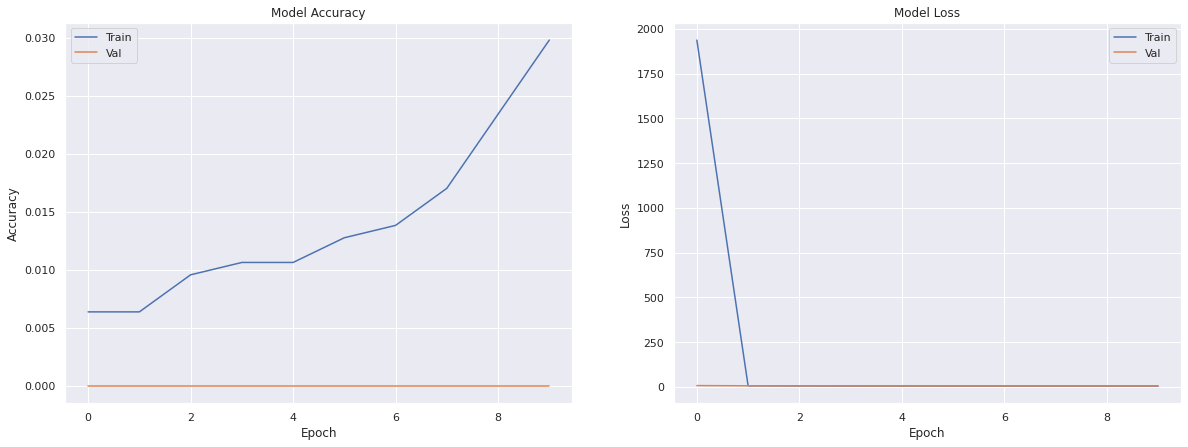

In [73]:
plotModelPerformanceCurvs(history)

#### Checking distribution of classes in traing data set

<AxesSubplot:xlabel='count', ylabel='Image class'>

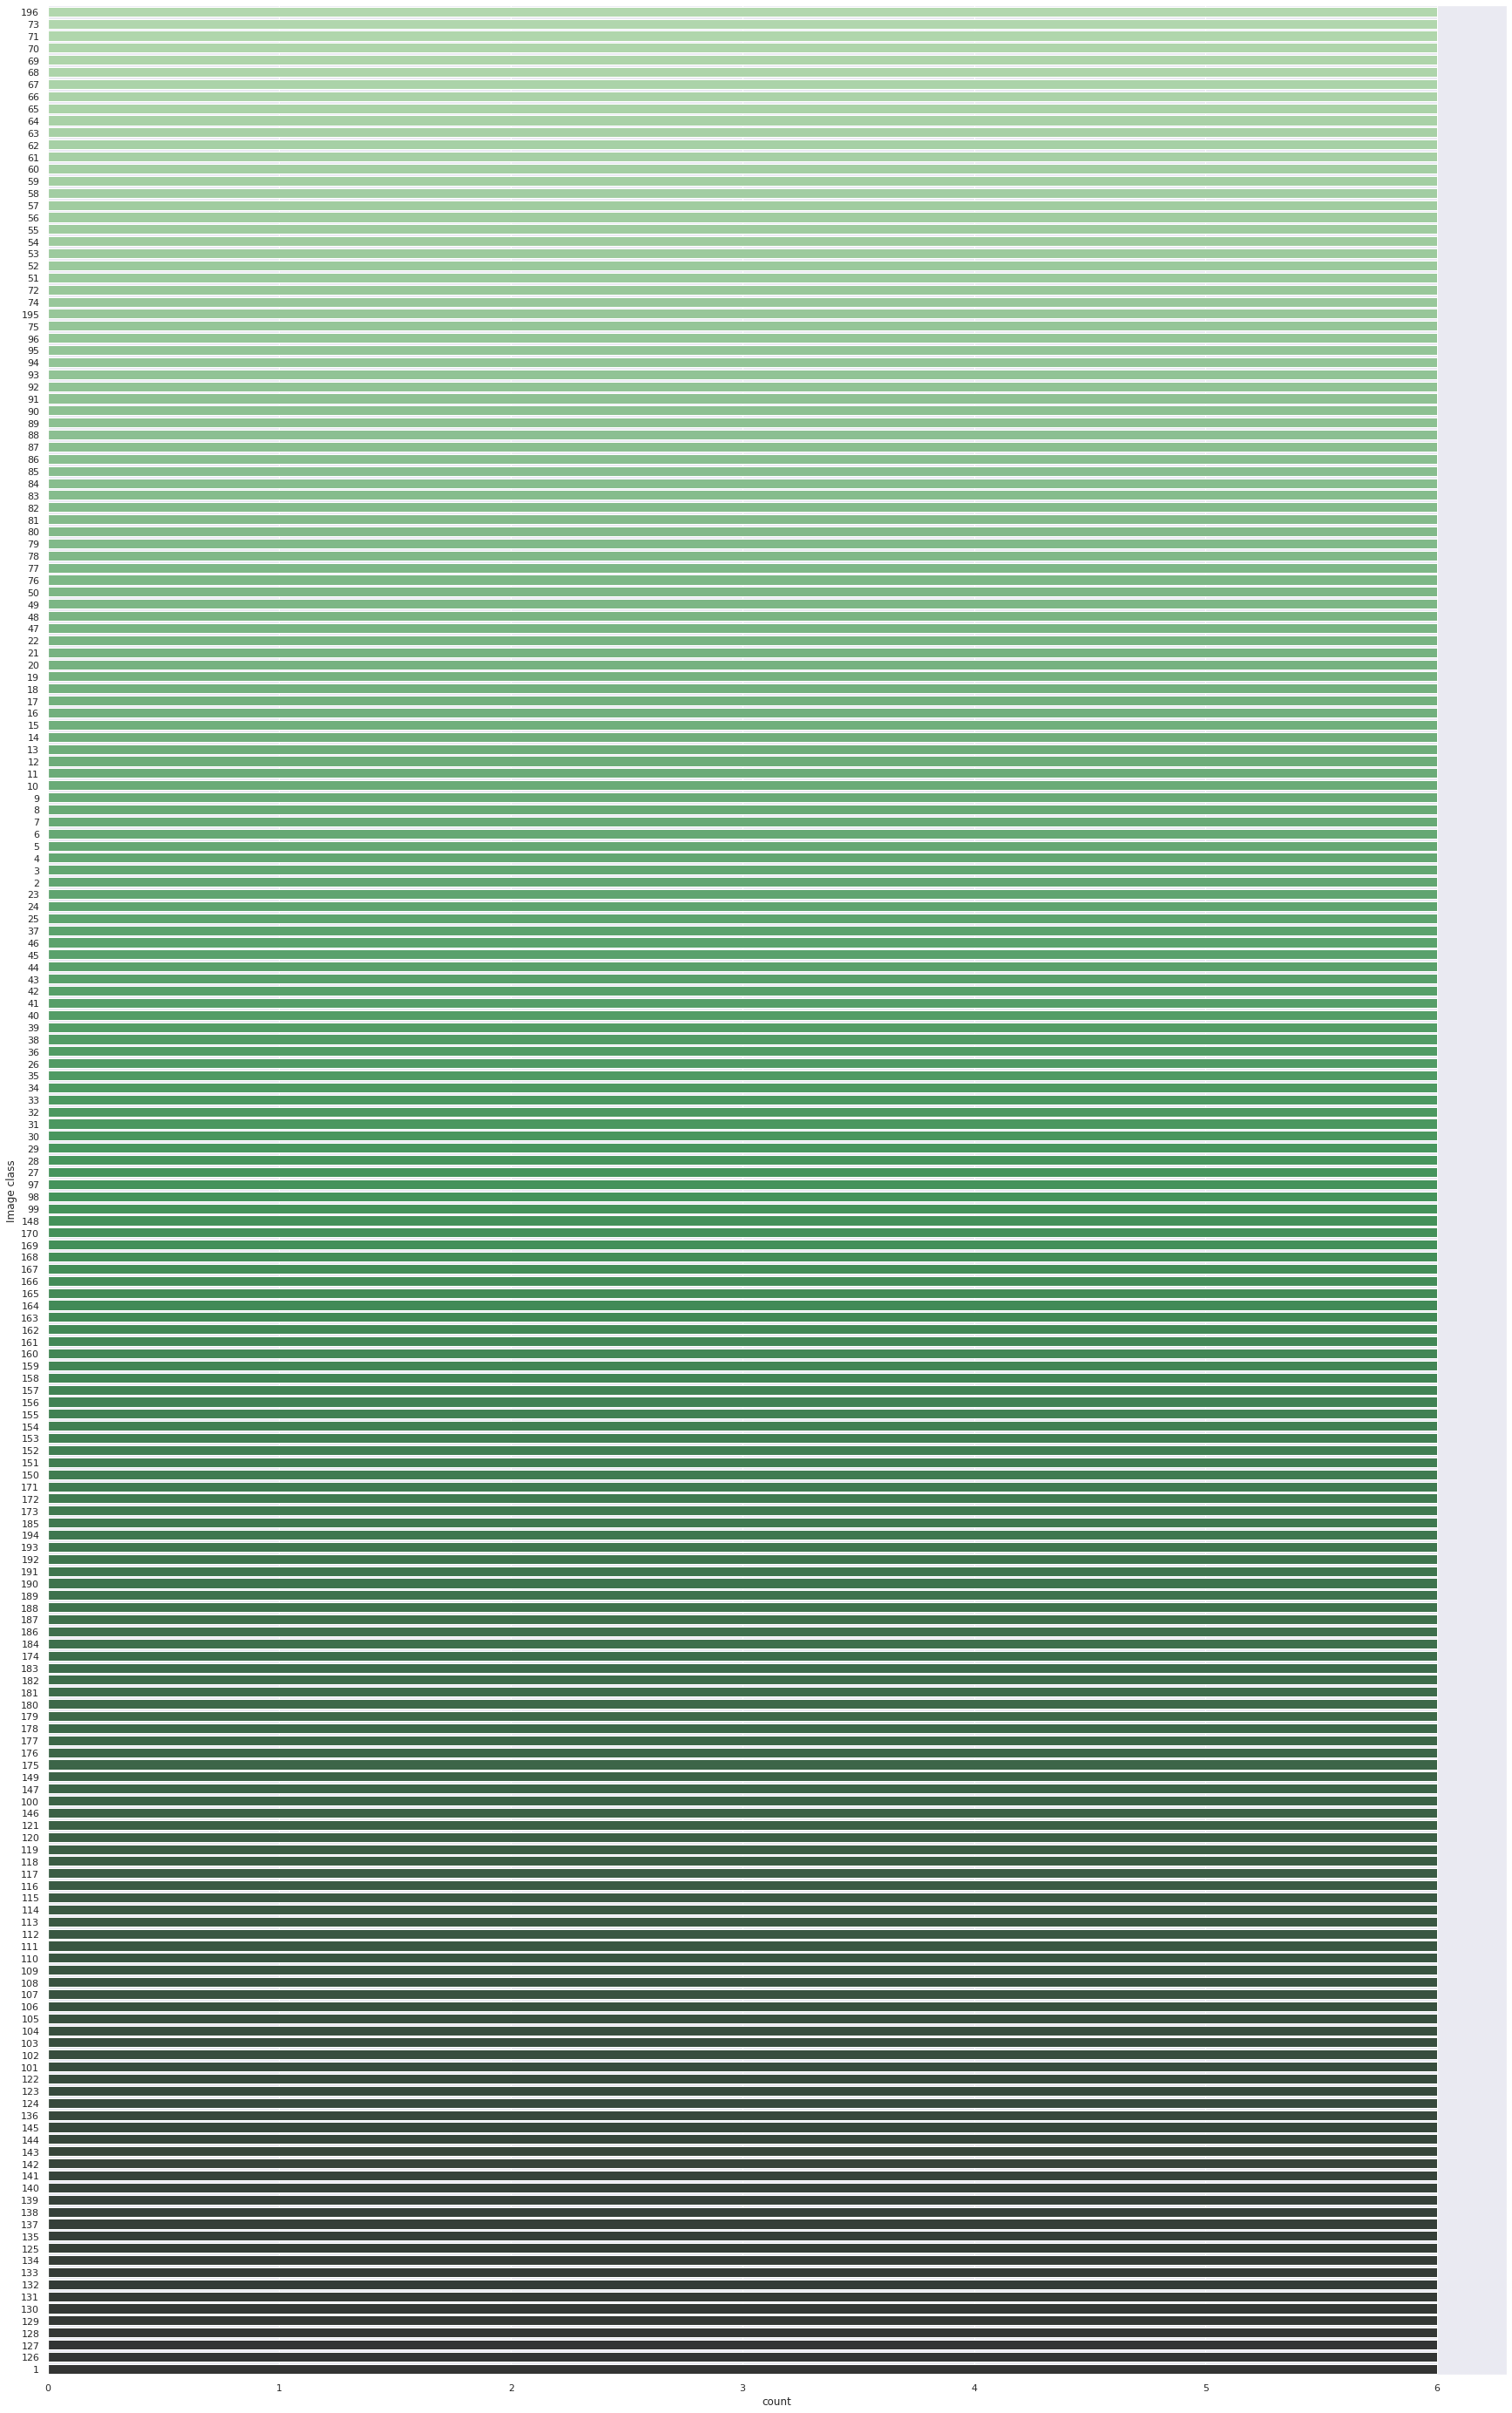

In [74]:
from matplotlib import pyplot
a4_dims = (30, 50)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.countplot(ax=ax,y=trainClassifReducedMergedImageDF['Image class'], data=trainClassifReducedMergedImageDF, palette="Greens_d",
              order=trainClassifReducedMergedImageDF['Image class'].value_counts().iloc[:196].index)

In [75]:
print(trainClassifReducedMergedImageDF['Image class'].value_counts())

196    6
73     6
71     6
70     6
69     6
      ..
129    6
128    6
127    6
126    6
1      6
Name: Image class, Length: 196, dtype: int64


### Here we can see there is imbalance in data as minimum number of image in a class is arround 25, let's take 25 images per class

### Let's take top 25 rows per car class

In [76]:
 trainClassifReducedMergedGRPDImageDF=trainClassifReducedMergedImageDF.groupby('Image class').head(6)

<AxesSubplot:xlabel='count', ylabel='Image class'>

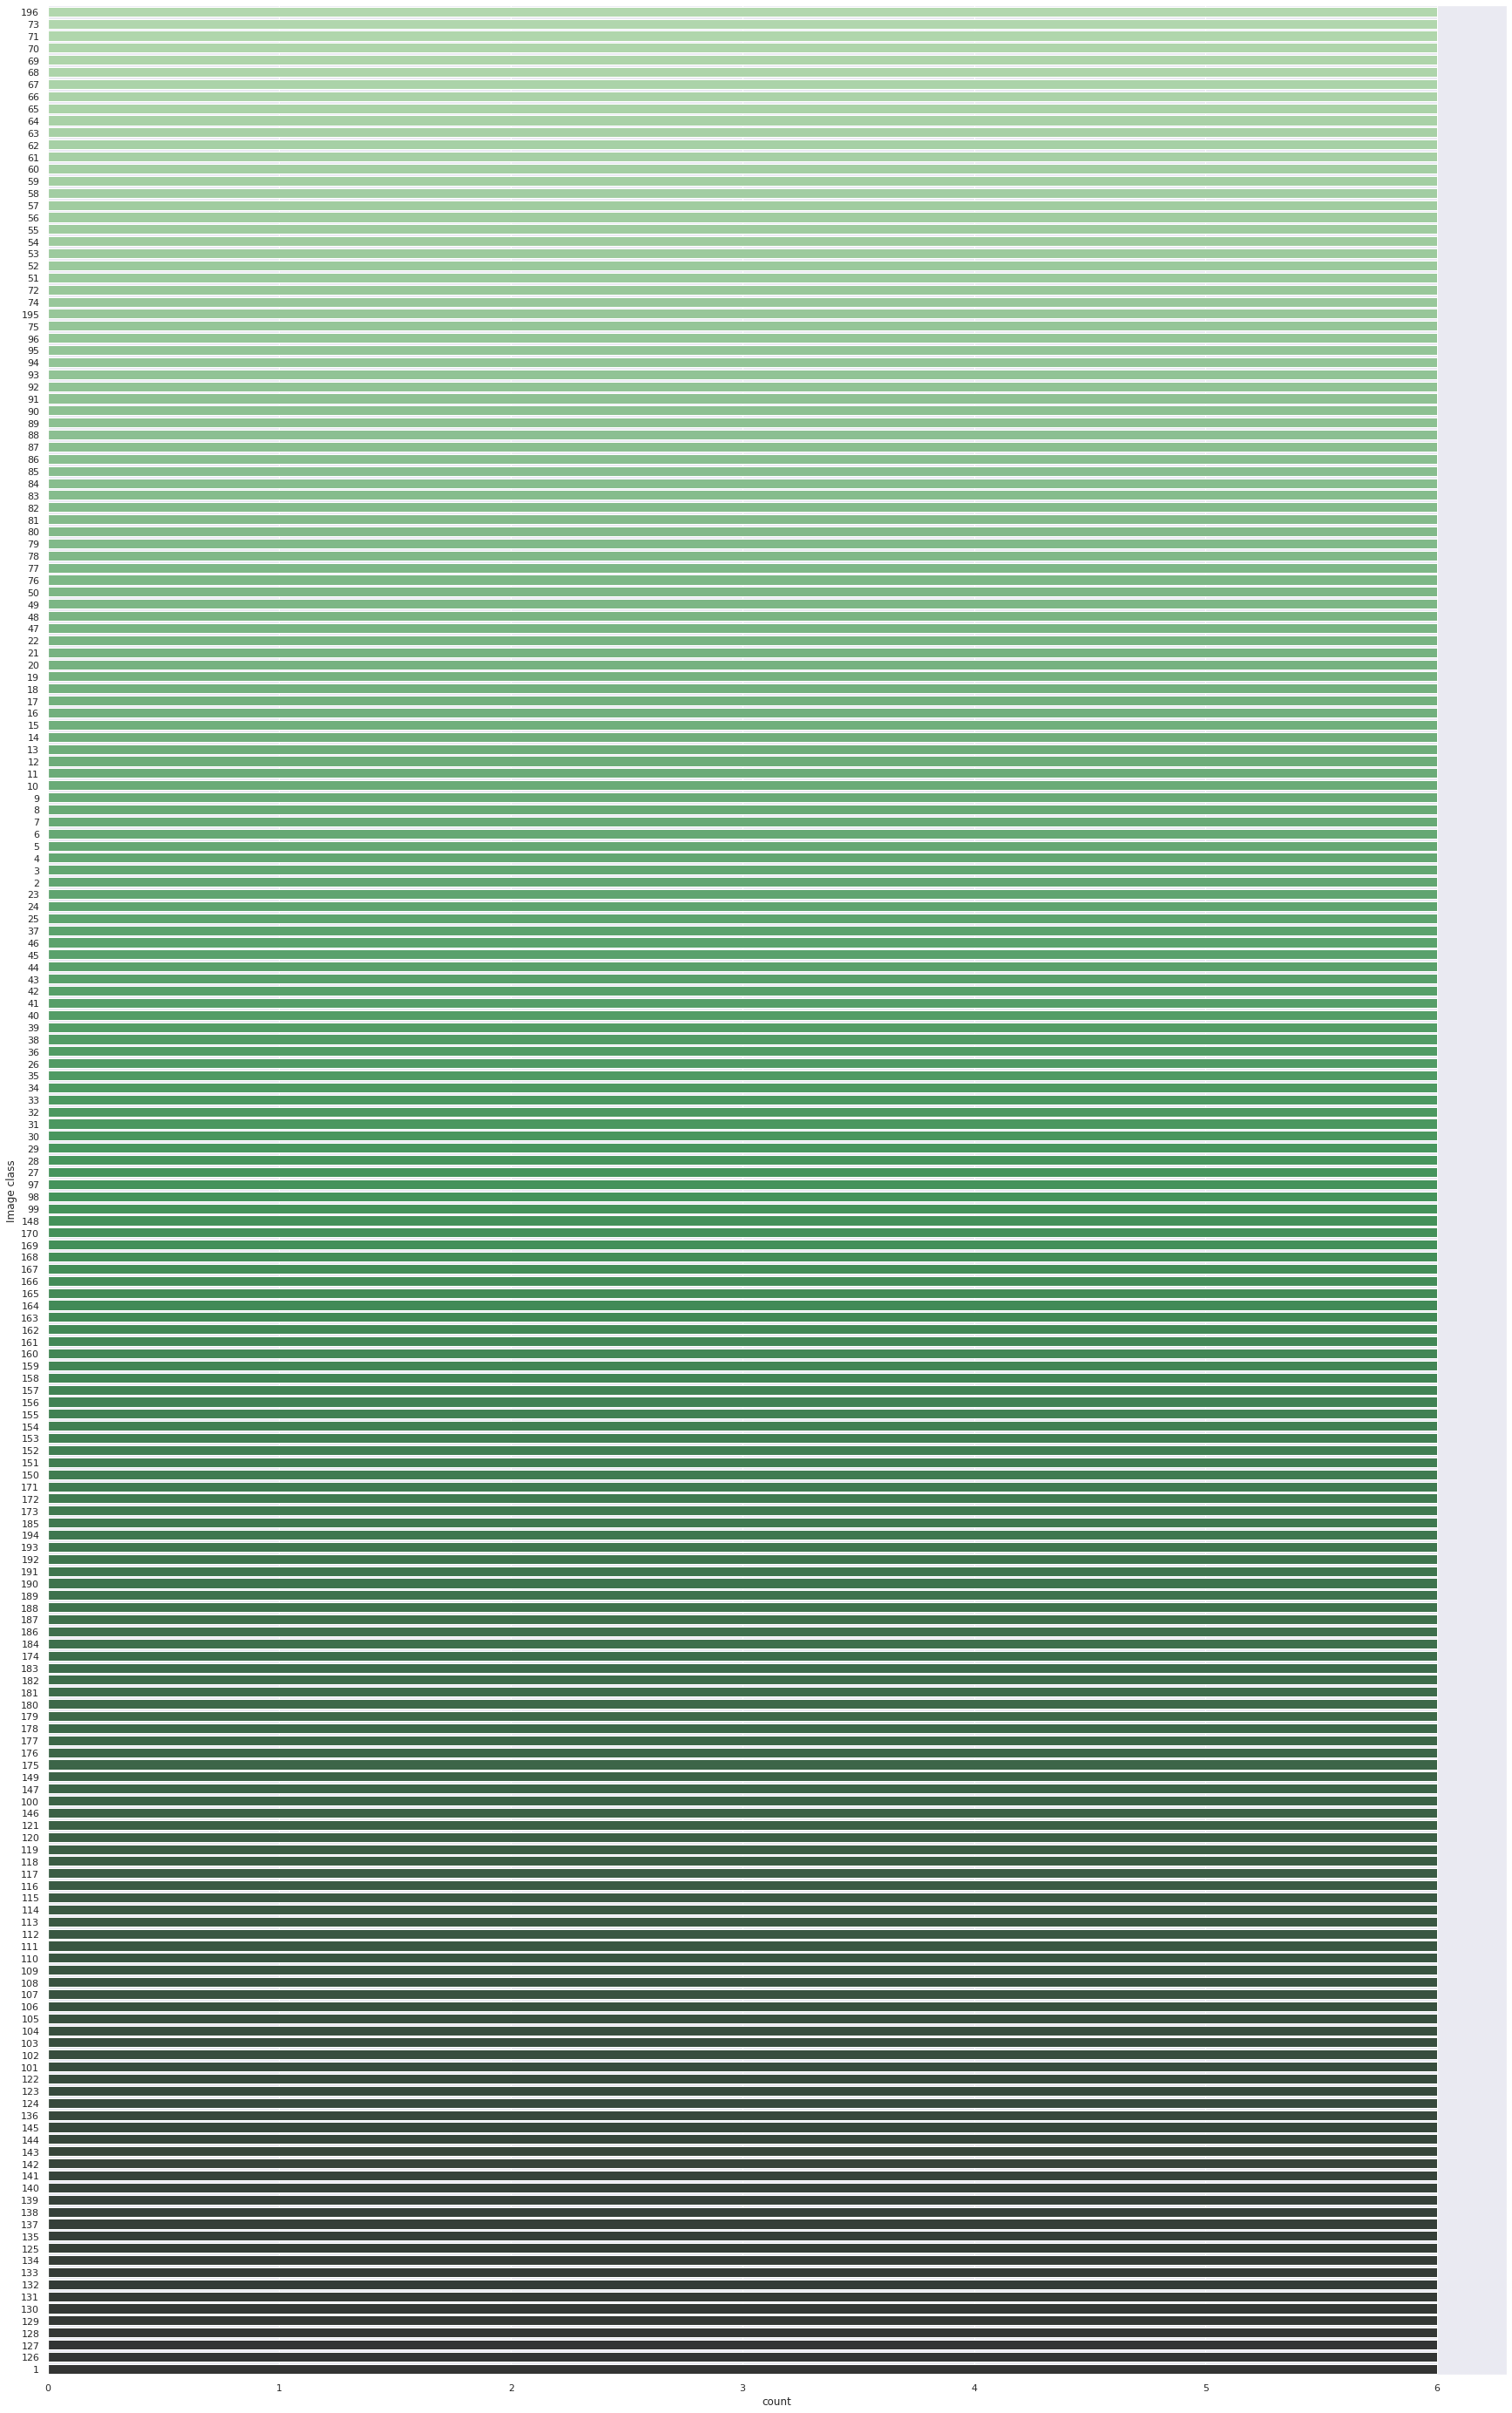

In [77]:
from matplotlib import pyplot
a4_dims = (30, 50)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.countplot(ax=ax,y=trainClassifReducedMergedGRPDImageDF['Image class'], data=trainClassifReducedMergedGRPDImageDF, palette="Greens_d",
              order=trainClassifReducedMergedGRPDImageDF['Image class'].value_counts().iloc[:196].index)

### Data imbalance has been settled

In [78]:
trainClassifReducedMergedGRPDImageDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1175
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Image Name               1176 non-null   object 
 1   image_array              1176 non-null   object 
 2   model                    1176 non-null   object 
 3   image_width_scale_fact   1176 non-null   float64
 4   image_height_scale_fact  1176 non-null   float64
 5   x0                       1176 non-null   int64  
 6   y0                       1176 non-null   int64  
 7   x1                       1176 non-null   int64  
 8   y1                       1176 non-null   int64  
 9   Image class              1176 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 141.1+ KB


### Let's check min,max values for tensors present in training data

In [79]:
trainClassifReducedMergedGRPDImageDF['image_array'][0]

array([[[  1],
        [  1],
        [  1],
        ...,
        [ 11],
        [ 11],
        [ 11]],

       [[  1],
        [  1],
        [  1],
        ...,
        [ 11],
        [ 11],
        [ 11]],

       [[  1],
        [  1],
        [  1],
        ...,
        [ 11],
        [ 11],
        [ 11]],

       ...,

       [[155],
        [155],
        [155],
        ...,
        [155],
        [155],
        [155]],

       [[155],
        [155],
        [155],
        ...,
        [155],
        [155],
        [155]],

       [[155],
        [155],
        [155],
        ...,
        [155],
        [155],
        [155]]], dtype=int32)

In [80]:
print('max val ' ,np.max(trainClassifReducedMergedGRPDImageDF['image_array'][0]))
print('min val ' ,np.min(trainClassifReducedMergedGRPDImageDF['image_array'][0]))

max val  171
min val  1


### Let's normalize the values

In [81]:
trainClassifReducedMergedGRPDImageDF['image_array']=trainClassifReducedMergedGRPDImageDF['image_array'].apply(lambda x: x/255)

In [82]:
print('max val ' ,np.max(trainClassifReducedMergedGRPDImageDF['image_array'][0]))
print('min val ' ,np.min(trainClassifReducedMergedGRPDImageDF['image_array'][0]))

max val  0.6705882352941176
min val  0.00392156862745098


### values are normalized between 0 to 1  

In [83]:
x_train_norm_classif = createFeatureTensor(trainClassifReducedMergedGRPDImageDF['image_array'],img_hight_classif,img_hight_classif,channels)

In [84]:
trainClassifReducedMergedGRPDImageDF.shape

(1176, 10)

In [85]:
y_train_norm_classif=trainClassifReducedMergedGRPDImageDF['Image class']
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le=LabelEncoder()
y_train_norm_classif_tensor=le.fit_transform(y_train_norm_classif)
y_train_norm_classif_tensor=to_categorical(y_train_norm_classif_tensor,196)

In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D,AveragePooling2D,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization

# Initialize the model
nnpmodel = Sequential()

# convolutional layer
nnpmodel.add(Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1), input_shape=(img_hight_classif,img_hight_classif,channels)))
nnpmodel.add(Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1)))
nnpmodel.add(BatchNormalization())
nnpmodel.add(ZeroPadding2D(padding=(1, 1)))
# convolutional layer
nnpmodel.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05)))
nnpmodel.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05)))
nnpmodel.add(BatchNormalization())


nnpmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid'))
nnpmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid'))
nnpmodel.add(BatchNormalization())
nnpmodel.add(MaxPool2D(pool_size=(2, 2), padding='same'))
nnpmodel.add(ZeroPadding2D(padding=(1, 1)))

nnpmodel.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01)))
nnpmodel.add(Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid'))
nnpmodel.add(BatchNormalization())

nnpmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
nnpmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
nnpmodel.add(BatchNormalization())

nnpmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1)))
nnpmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1)))
nnpmodel.add(BatchNormalization())
nnpmodel.add(MaxPool2D(pool_size=(2, 2)))

nnpmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
nnpmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02)))
nnpmodel.add(BatchNormalization())

nnpmodel.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05)))
nnpmodel.add(Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid'))
nnpmodel.add(BatchNormalization())

nnpmodel.add(Flatten())
nnpmodel.add(Dense(32, activation='relu'))
nnpmodel.add(Dropout(0.3))

nnpmodel.add(Dense(32, activation='relu'))
nnpmodel.add(Dropout(0.2))

# output layer
#Add Fully Connected Layer with 196 units and activation function as 'softmax'
nnpmodel.add(Dense(196, activation='softmax',name='visualized_layer'))

In [88]:
nnpmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 146, 146, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 146, 146, 16)      64        
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 146, 146, 32)      4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 144, 144, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 144, 144, 32)     

In [89]:
#plot_model(nnpmodel, to_file='./nnpmodel_plot.png', show_shapes=True, show_layer_names=True)

In [90]:
INIT_LR = 1e-1
BS = 64
EPOCHS = 20

In [91]:
from keras.optimizers import SGD,Adam
opt = SGD(lr=0.001, momentum=0.9)
#opt=SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / EPOCHS)
#opt = Adam(lr=0.001)


In [92]:
x_train_norm_classif.shape

(1176, 150, 150, 3)

In [93]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
Callbacks=[EarlyStopping(patience=2, restore_best_weights=True), 
           ReduceLROnPlateau(patience=2), 
           ModelCheckpoint(filepath='ImageDataGen_Size150_oneHOT_ClassWeights_Callbacks_SGD_L2.h5', save_best_only=True)]   


In [94]:
#nnpmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
nnpmodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#nnpmodel.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [95]:
x_train_classif.shape

(1176, 150, 150, 3)

In [96]:
y_train_norm_classif_tensor.shape

(1176, 196)

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train_norm_classif,y_train_norm_classif_tensor, test_size=0.33)

In [98]:
nnphistory=nnpmodel.fit( x=X_train,y=y_train, batch_size=BS, epochs=EPOCHS,shuffle=True,verbose=1,validation_data=(X_test,y_test),callbacks=Callbacks)

Epoch 1/20
13/13 [==============================] - 46s 3s/step - loss: 18.7194 - accuracy: 0.0049 - val_loss: 18.5208 - val_accuracy: 0.0051
Epoch 2/20
13/13 [==============================] - 28s 2s/step - loss: 18.5877 - accuracy: 0.0016 - val_loss: 18.3443 - val_accuracy: 0.0026
Epoch 3/20
13/13 [==============================] - 28s 2s/step - loss: 18.4212 - accuracy: 0.0063 - val_loss: 18.1471 - val_accuracy: 0.0026
Epoch 4/20
13/13 [==============================] - 28s 2s/step - loss: 18.1752 - accuracy: 0.0088 - val_loss: 17.9330 - val_accuracy: 0.0103
Epoch 5/20
13/13 [==============================] - 28s 2s/step - loss: 17.9637 - accuracy: 0.0033 - val_loss: 17.7251 - val_accuracy: 0.0077
Epoch 6/20
13/13 [==============================] - 28s 2s/step - loss: 17.7044 - accuracy: 0.0041 - val_loss: 17.5165 - val_accuracy: 0.0000e+00
Epoch 7/20
13/13 [==============================] - 28s 2s/step - loss: 17.5150 - accuracy: 0.0146 - val_loss: 17.3154 - val_accuracy: 0.0051
Ep

In [99]:
#for layer in nnpmodel.layers: print("layer config :: ",layer.get_config(), "layer weight :: ",layer.get_weights())

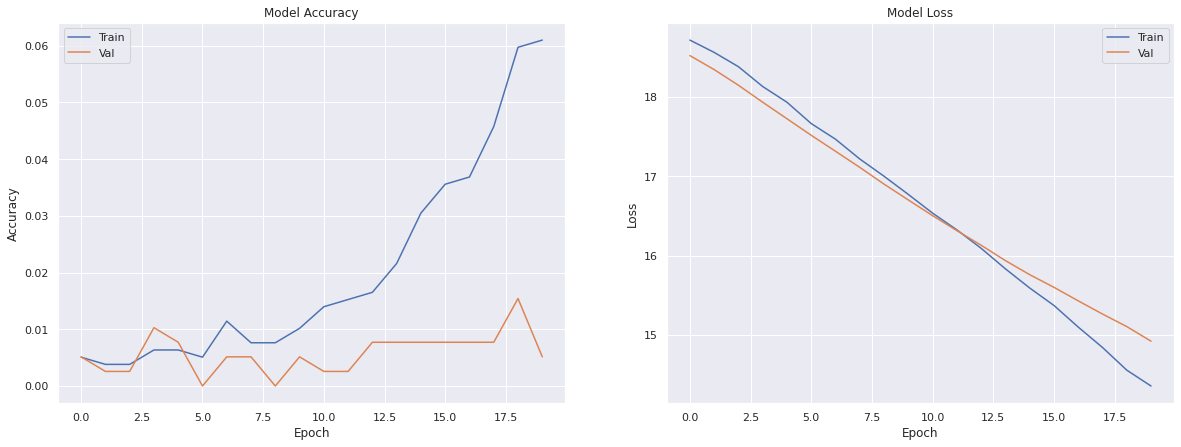

In [100]:
plotModelPerformanceCurvs(nnphistory)

### Final loss and accuracy

In [101]:
nnpmodel.evaluate(x_test_classif, y_test_tensor)

37/37 [==============================] - 35s 821ms/step - loss: 49.9431 - accuracy: 0.0051


[49.94306182861328, 0.005102040711790323]

### To denoising image

In [102]:

# importing libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import filters

In [103]:
# Reading image from folder where it is stored
#img = cv2.imread('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/AM General Hummer SUV 2000/02050.jpg')
#img=cv2.imread('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/AM General Hummer SUV 2000/00522.jpg')
img = cv2.imread('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Acura Integra Type R 2001/00198.jpg')
  
# denoising of image saving it into dst image
#dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15)
#dst = remove_background(img, threshold=128.)


In [104]:

sobel = filters.sobel(img)

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 200

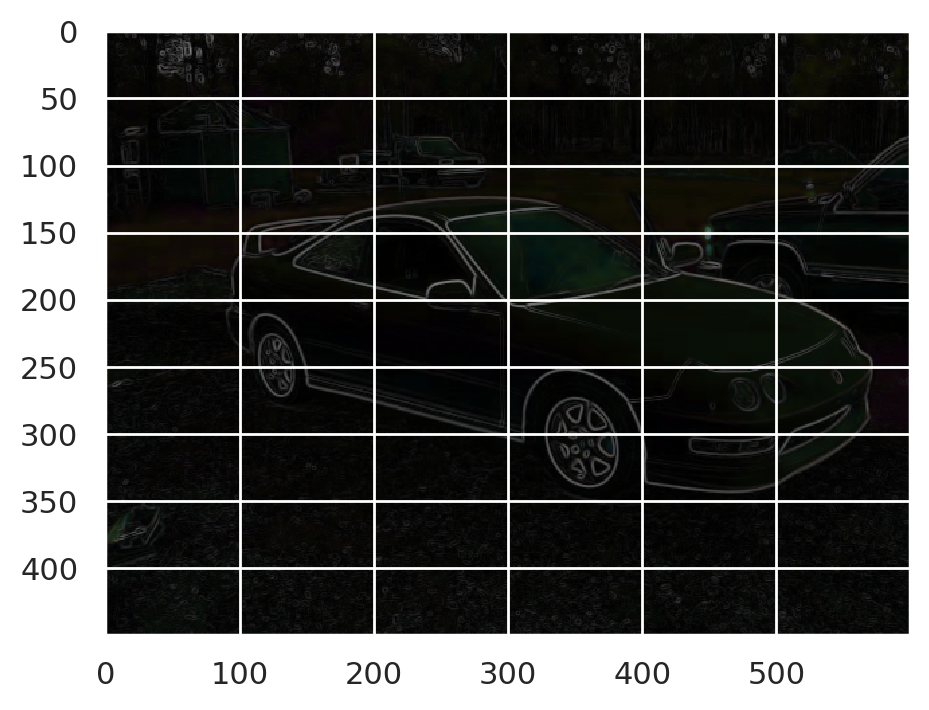

In [106]:
plt.imshow(sobel)

In [107]:
#cv2.imwrite('./dst.jpg', sobel)

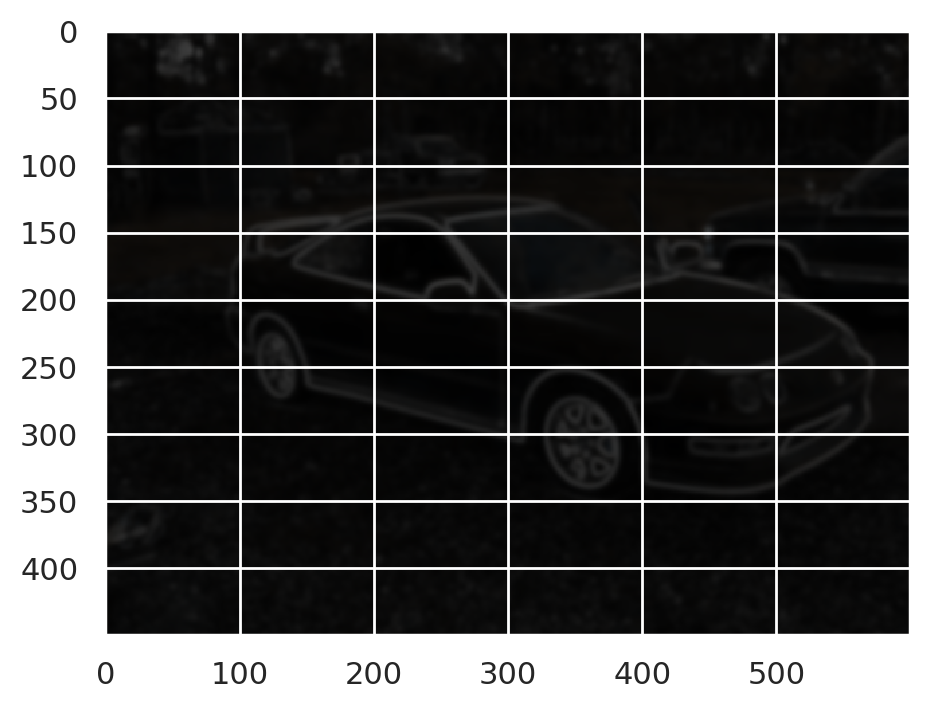

In [108]:
blurred = filters.gaussian(sobel, sigma=2.0,multichannel=False)
plt.imshow(blurred)

In [109]:
light_spots = np.array((img > 180).nonzero()).T

In [110]:
light_spots.shape

(77414, 3)

Text(0.5, 1.0, 'light spots in image')

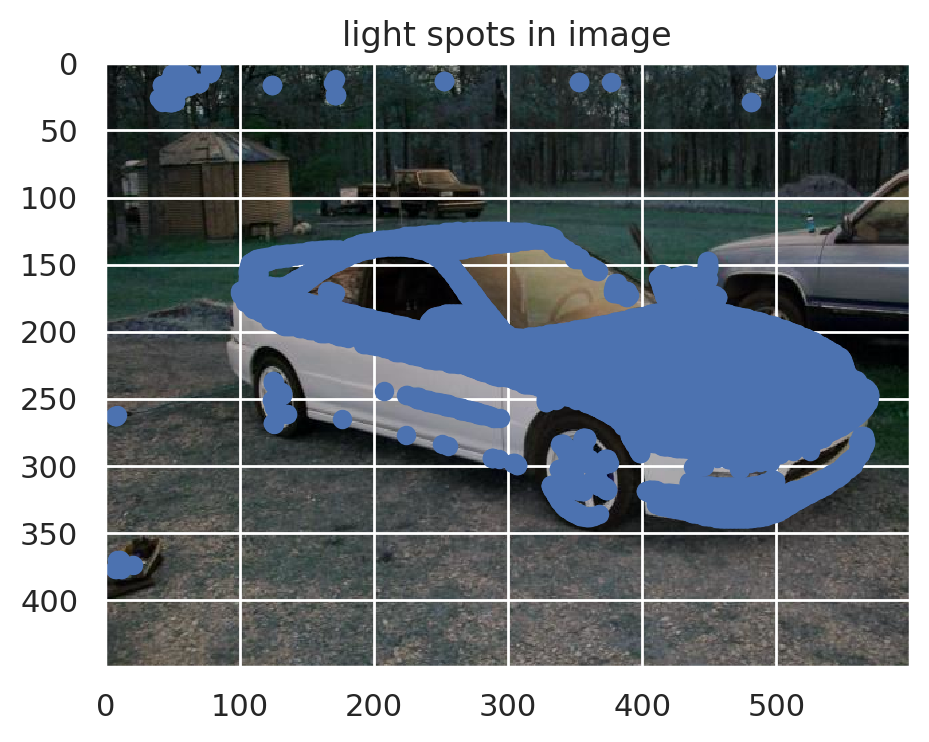

In [111]:
plt.plot(light_spots[:, 1], light_spots[:, 0], 'o')
plt.imshow(img)
plt.title('light spots in image')

In [112]:
dark_spots = np.array((img < 2).nonzero()).T

In [113]:
dark_spots.shape

(3774, 3)

Text(0.5, 1.0, 'dark spots in image')

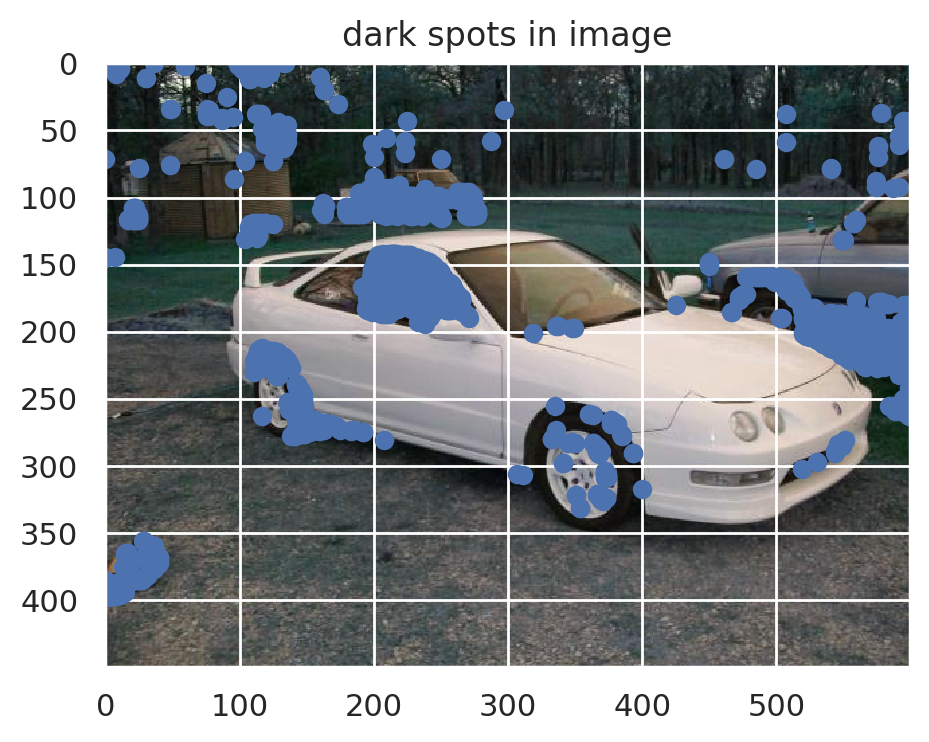

In [114]:
plt.plot(dark_spots[:, 1], dark_spots[:, 0], 'o')
plt.imshow(img)
plt.title('dark spots in image')

In [115]:
from scipy import ndimage as ndi
bool_mask = np.zeros(img.shape, dtype=np.bool)
bool_mask[tuple(light_spots.T)] = True
bool_mask[tuple(dark_spots.T)] = True
seed_mask, num_seeds = ndi.label(bool_mask)
num_seeds

630

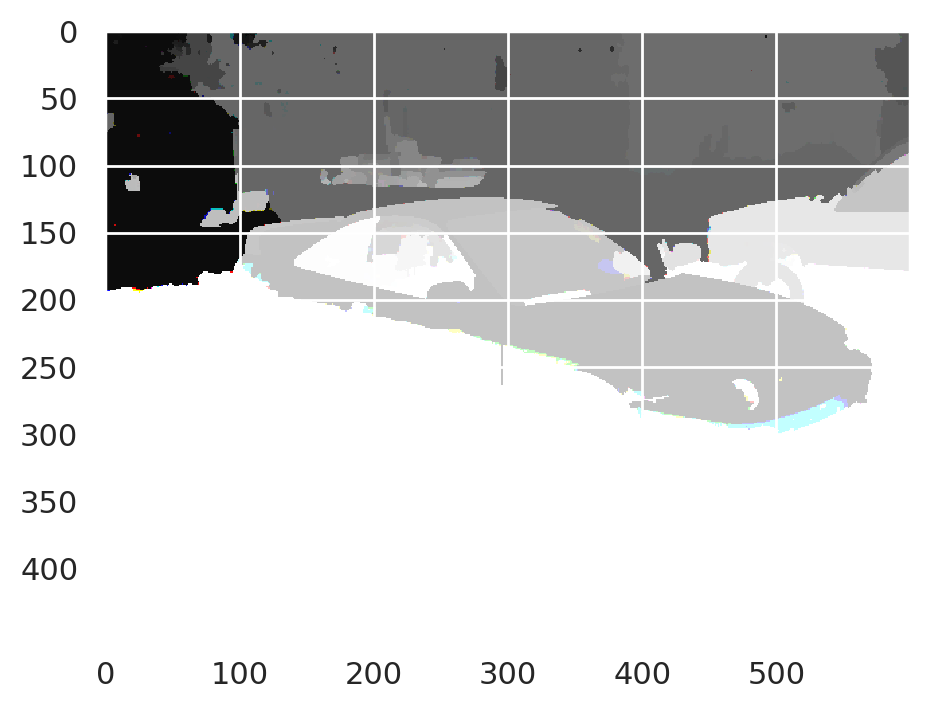

In [116]:
from skimage import segmentation
ws = segmentation.watershed(sobel, seed_mask)
plt.imshow(ws)

In [117]:
background = max(set(ws.ravel()), key=lambda g: np.sum(ws == g))
background

474

In [118]:
background_mask = (ws == background)

In [119]:
background_mask

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [False, False, False],
        [False, False, False],
        [False,

In [120]:
#plt.imshow(background_mask)

In [121]:
cv2.imwrite('./dst.jpg', ws)

True

#### The Grad-CAM algorithm

In [122]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

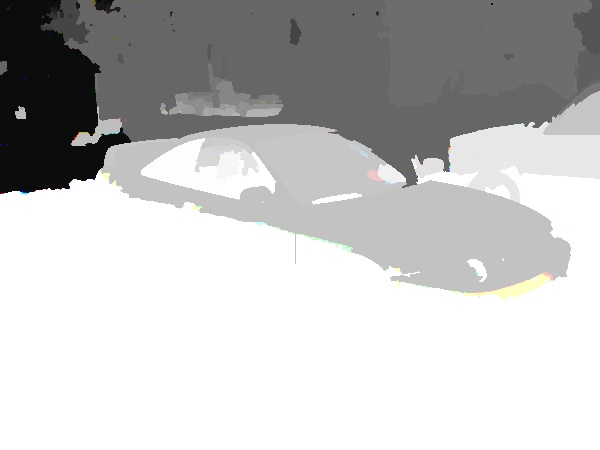

In [123]:
from keras import applications
from keras import utils
model_builder = applications.xception.Xception
img_size = (150, 150)
preprocess_input = applications.xception.preprocess_input
decode_predictions = applications.xception.decode_predictions

last_conv_layer_name = "visualized_layer"

# The local path to our target image
#img_path = "../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Acura Integra Type R 2001/00198.jpg"

#img_path ="../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/AM General Hummer SUV 2000/00522.jpg"
#img_path="../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/AM General Hummer SUV 2000/02050.jpg"
img_path="./dst.jpg"
display(Image(img_path))

In [124]:
from keras import preprocessing

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [125]:
import tensorflow as tf
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    print(grads)
    #pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    pooled_grads = tf.reduce_mean(grads,(0,1,2))
    print(pooled_grads)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [126]:
img_array=preprocess_input(get_img_array(img_path, size=img_size))

In [127]:
# Print what the top predicted class is
preds = nnpmodel.predict(img_array)
preds
labels = (preds > 0.7).astype(np.int)
labels
#print("Predicted:", decode_predictions(preds, top=1)[0])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [128]:
# Remove last layer's softmax
nnpmodel.layers[-1].activation = None

In [129]:
heatmap=make_gradcam_heatmap(img_array, nnpmodel, 'batch_normalization_7', pred_index=None)
#heatmap=make_gradcam_heatmap(img_array, nnmodel, 'conv2d_1', pred_index=None)


tf.Tensor(
[[[[-9.01034975e-04  2.33283453e-03  2.15580361e-03 ... -2.46886979e-04
     2.26084085e-04 -1.50631601e-03]
   [ 7.58847804e-04 -1.05931552e-03 -3.53728072e-04 ...  3.98959313e-03
    -2.03344249e-03 -1.10550574e-03]
   [ 1.47433113e-03  7.17260991e-04  2.71966099e-04 ...  3.47336783e-04
     9.67543223e-04 -1.17252441e-03]
   ...
   [-2.13463162e-03  1.90562481e-04 -2.99190963e-03 ...  3.34402593e-03
     1.27316837e-03 -1.64804514e-05]
   [-8.21944908e-04  9.92389861e-04 -5.69762371e-04 ... -1.23003824e-03
    -1.06704817e-03 -9.74630646e-04]
   [ 2.96961662e-04 -4.67170903e-04 -2.25653779e-03 ... -2.46587140e-03
    -2.26175692e-03  8.99564184e-04]]

  [[-4.06188308e-04 -2.14554323e-03  4.13616654e-05 ... -5.72070188e-04
     1.83936860e-03 -9.55744763e-04]
   [ 2.28900951e-03 -1.25362072e-04  7.41472177e-04 ... -1.36643834e-03
    -2.40283692e-03  7.85915821e-04]
   [-1.30459073e-03 -6.53712428e-04  8.05930467e-05 ...  4.48450388e-04
    -9.53014591e-04  7.12365028e-04]

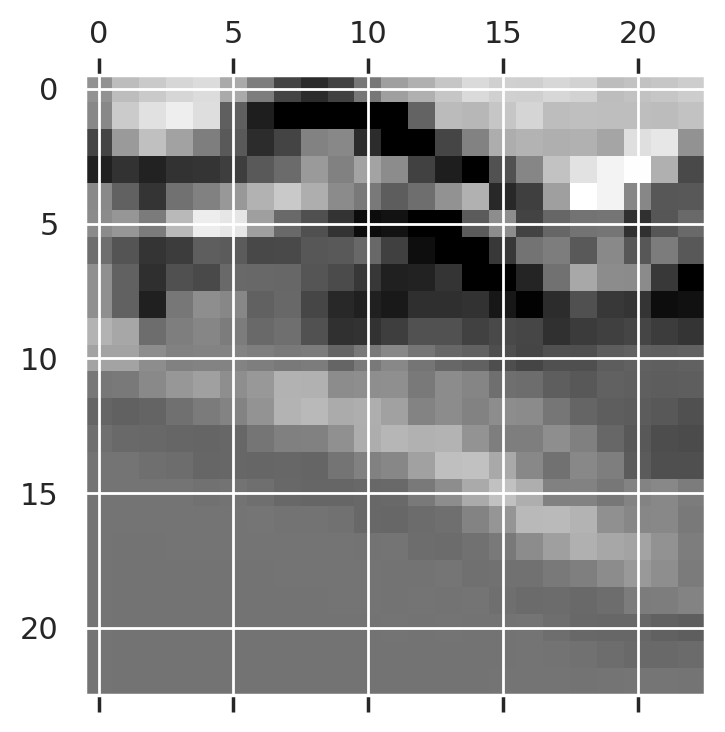

In [130]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

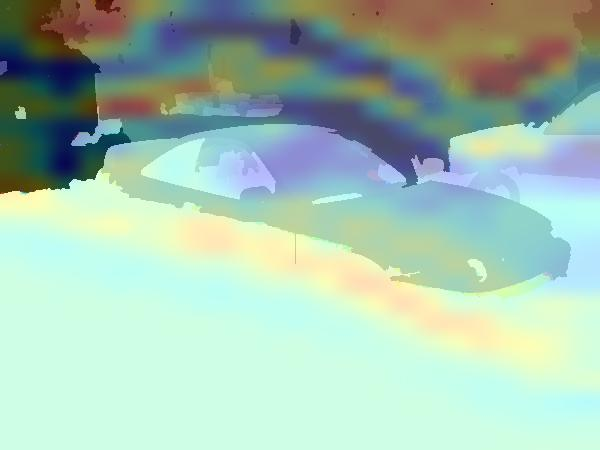

In [131]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = preprocessing.image.load_img(img_path)
    img = preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

### Let's use keras image data generator for classification

In [132]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

In [133]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
validation_data_dir = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'
nb_train_samples = 8144
nb_validation_samples = 1000
epochs = 50
batch_size = 16

In [134]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [135]:
idgmodel = Sequential()
idgmodel.add(Conv2D(32, (3, 3), input_shape=input_shape))
idgmodel.add(Activation('relu'))
idgmodel.add(MaxPooling2D(pool_size=(2, 2)))

idgmodel.add(Conv2D(32, (3, 3)))
idgmodel.add(Activation('relu'))
idgmodel.add(MaxPooling2D(pool_size=(2, 2)))

idgmodel.add(Conv2D(64, (3, 3)))
idgmodel.add(Activation('relu'))
idgmodel.add(MaxPooling2D(pool_size=(2, 2)))

idgmodel.add(Flatten())
idgmodel.add(Dense(64))
idgmodel.add(Activation('relu'))
idgmodel.add(Dropout(0.5))
idgmodel.add(Dense(196))
idgmodel.add(Activation('sigmoid'))

idgmodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [136]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.4,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    #zca_whitening=True,
    channel_shift_range=1.0,
    brightness_range=(0.34,0.68),
    vertical_flip=True,
    fill_mode='nearest'
)

In [137]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [138]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [139]:
imgdgHist=idgmodel.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)



Epoch 1/50
509/509 [==============================] - 190s 372ms/step - loss: 5.2826 - accuracy: 0.0065 - val_loss: 5.2768 - val_accuracy: 0.0111
Epoch 2/50
509/509 [==============================] - 144s 284ms/step - loss: 5.2776 - accuracy: 0.0056 - val_loss: 5.2748 - val_accuracy: 0.0091
Epoch 3/50
509/509 [==============================] - 143s 282ms/step - loss: 5.2764 - accuracy: 0.0094 - val_loss: 5.2753 - val_accuracy: 0.0091
Epoch 4/50
509/509 [==============================] - 145s 283ms/step - loss: 5.2758 - accuracy: 0.0063 - val_loss: 5.2756 - val_accuracy: 0.0040
Epoch 5/50
509/509 [==============================] - 144s 282ms/step - loss: 5.2745 - accuracy: 0.0082 - val_loss: 5.2726 - val_accuracy: 0.0060
Epoch 6/50
509/509 [==============================] - 144s 282ms/step - loss: 5.2747 - accuracy: 0.0090 - val_loss: 5.2706 - val_accuracy: 0.0141
Epoch 7/50
509/509 [==============================] - 143s 281ms/step - loss: 5.2752 - accuracy: 0.0081 - val_loss: 5.2697 -

In [140]:
idgmodel.save_weights('img_aug_model_first_try.h5')

In [141]:
idgmodel.evaluate(x_test_classif, y_test_tensor)

37/37 [==============================] - 2s 33ms/step - loss: 5.9321 - accuracy: 0.0043


[5.932104587554932, 0.004251700825989246]

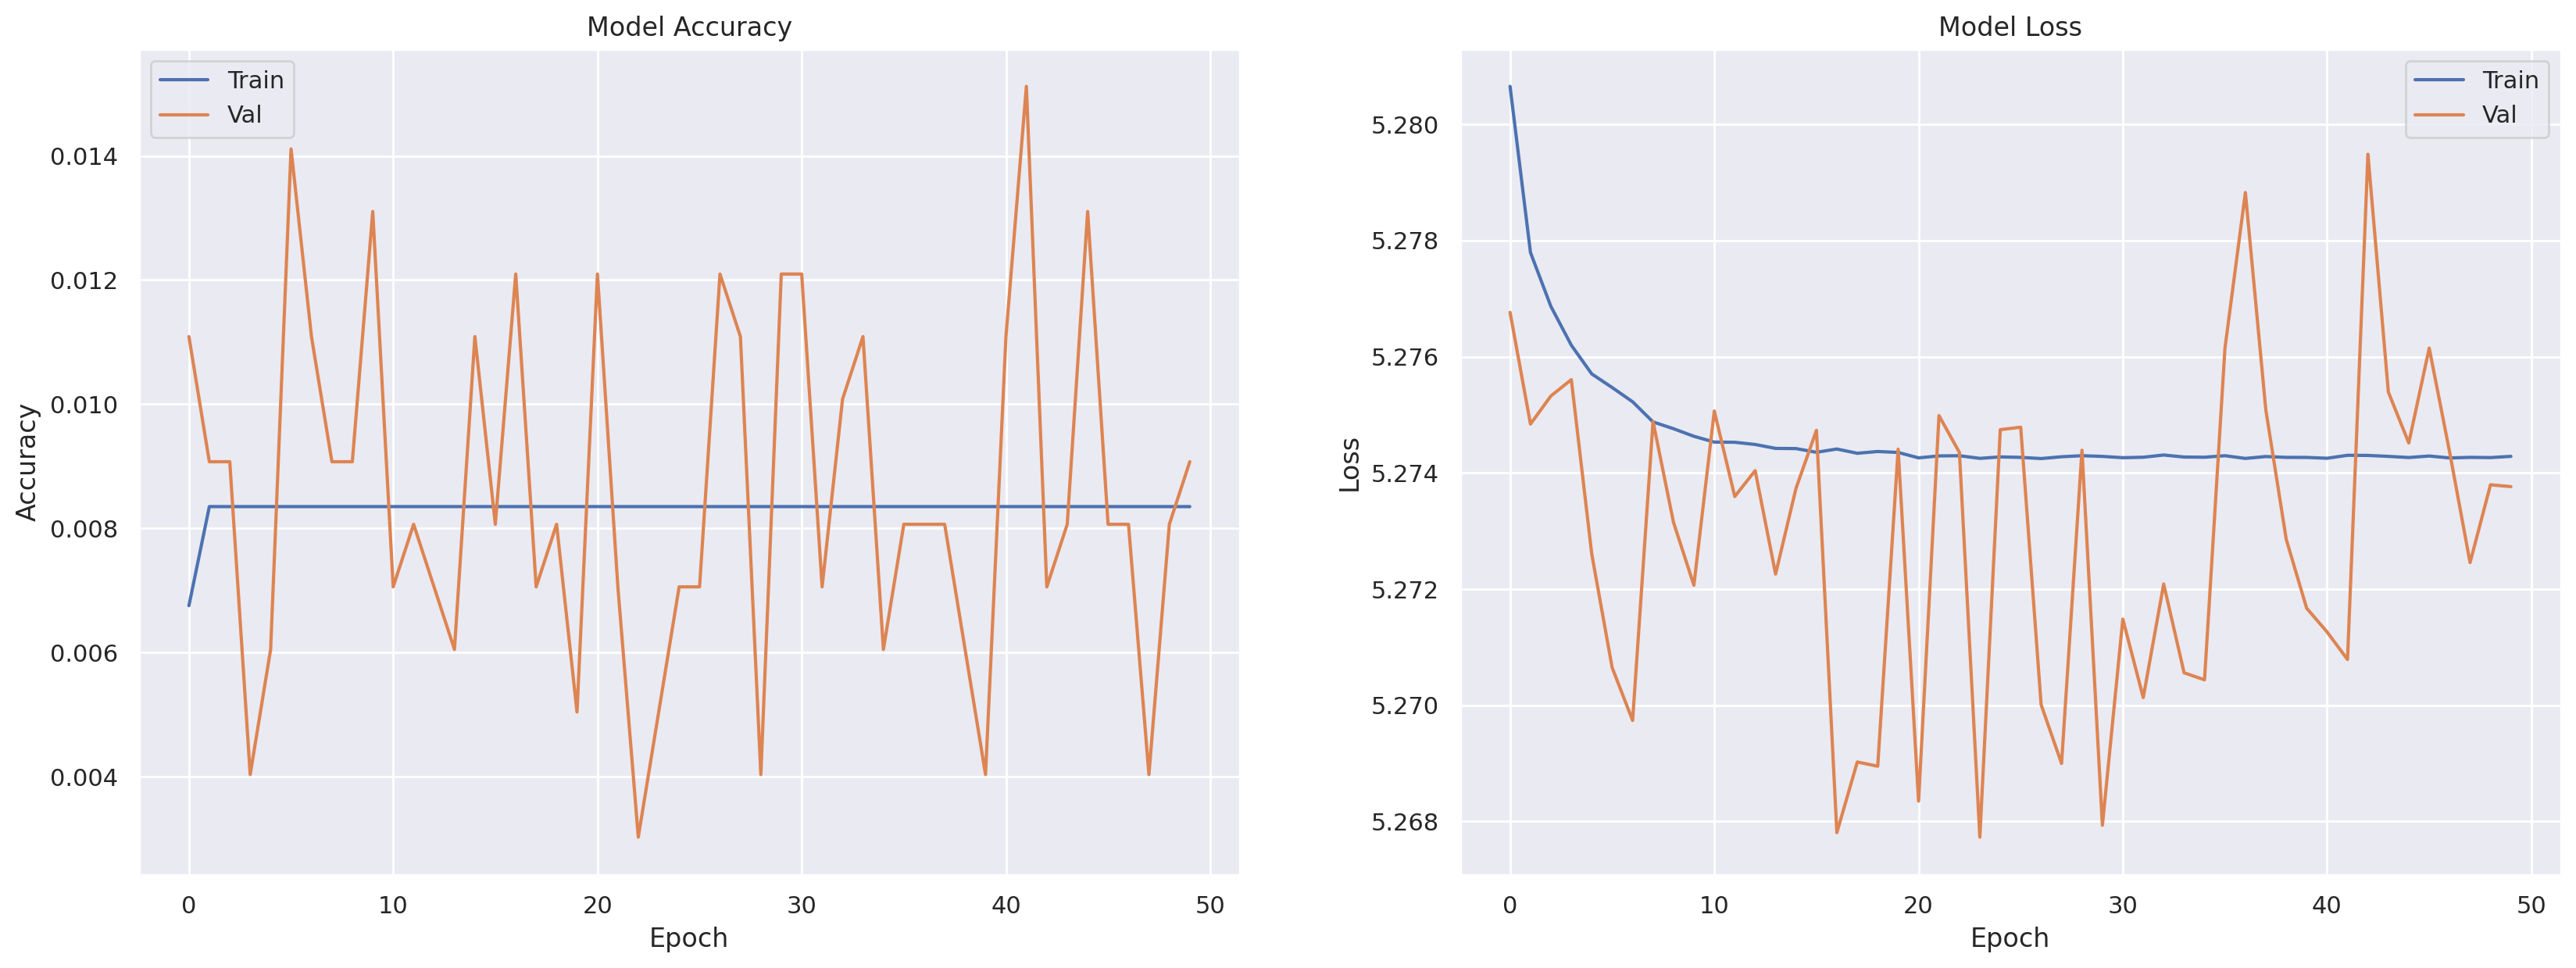

In [142]:
plotModelPerformanceCurvs(imgdgHist)

### Let's use tranfer learning: EfficientNet

In [143]:
from tensorflow.keras.applications import EfficientNetB0
enmodel = EfficientNetB0(weights='imagenet')

21839872/21834768 [==============================] - 1s 0us/step


In [144]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [145]:
batch_size = 64

In [146]:
size = (IMG_SIZE, IMG_SIZE)

In [147]:
trainTransfImageDF=createImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',(IMG_SIZE,IMG_SIZE,channels),"grayscale",6)

### creating bounding box labels

In [148]:
y_train=createBondingBoxTensor(trainReducedMergedImageDF,'x0_scaled','y0_scaled','x1_scaled','y1_scaled')
y_test=createBondingBoxTensor(testReducedMergedImageDF,'x0_scaled','y0_scaled','x1_scaled','y1_scaled')

NameError: name 'trainReducedMergedImageDF' is not defined

In [149]:
y_train.shape

(787, 196)

In [150]:
y_test.shape

(389, 196)

### Create the model for bounding box predictions

In [151]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

def create_model(imgWidth,imgHeight,trainable=True):
    model = MobileNet(input_shape=(imgWidth, imgHeight, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=4, name="coords")(x0)
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    x2 = Reshape((4,))(x1) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=x2)

### Define evaluation metric

In [152]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [153]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

###  Initialize the model and print summary

In [154]:
model = create_model(IMAGE_WIDTH,IMAGE_HEIGHT,False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

17227776/17225924 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
____________________________________________________________

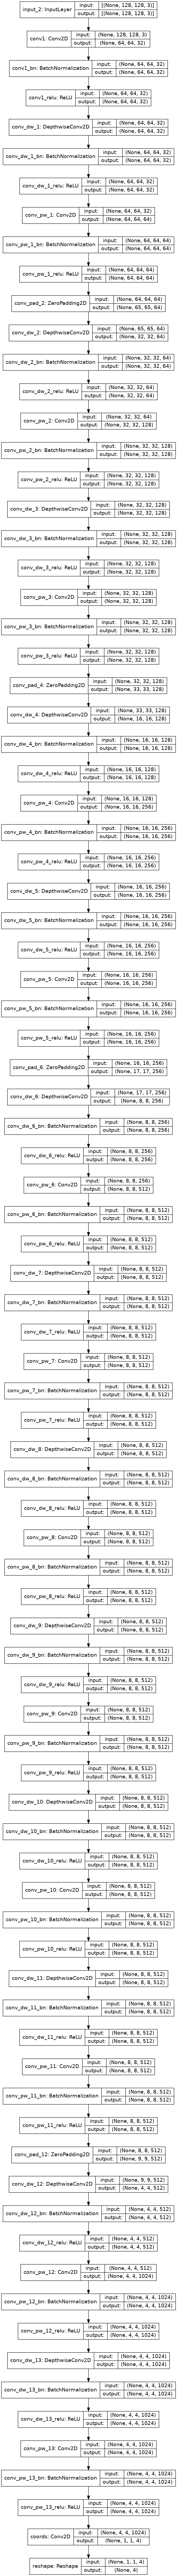

In [155]:
plot_model(model, to_file='./mb_model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model
* loss: "mean_squared_error"
* metrics: IoU
* optimizer: "adam"

In [156]:
# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE
#model.compile(loss="mean_squared_error", optimizer="adam") # Regression loss is MSE

### Training the model
Fit the model to the dataset<br/>

* Use early stopping
* fit the model
* give train data - training features and labels
    ** batch size: 32
    ** epochs: 10
    ** give validation data - testing features and labels

In [157]:
pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.5 MB 34 kB/s 
     |████████████████████████████████| 50 kB 4.4 MB/s 
     |████████████████████████████████| 3.0 MB 32.6 MB/s 
     |████████████████████████████████| 411 kB 29.1 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [158]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [159]:
x_train[0]

NameError: name 'x_train' is not defined

In [160]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [161]:
# Use earlystopping
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

# Fit the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32,callbacks=[callback])
#model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

NameError: name 'x_train' is not defined

### Final loss and accuracy

In [162]:
model.evaluate(x_test, y_test)

NameError: name 'x_test' is not defined

### Test the model on an image from test data

In [163]:
def drowPredictedBBOnImage(fileName,imgResizeTuple,imageArrayCol,colorScheme):
    df=loadSingleScoringImage(filename,imgResizeTuple,colorScheme)
    df[imageArrayCol]=df[imageArrayCol]/255
    predImageTensor=createFeatureTensor(df[imageArrayCol],IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL)
    region = model.predict(x=predImageTensor)[0] # Predict the BBox
    x0=region[0]
    y0=region[1]
    x1=region[2]
    y1=region[3]
    # Create figure and axes
    fig,ax = plt.subplots(1)
    # Display the image
    ax.imshow(df[imageArrayCol][0])
    # Create a Rectangle patch
    rect = patches.Rectangle((x0,y0),x1-x0,y1-y0, linewidth=2, edgecolor='b', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

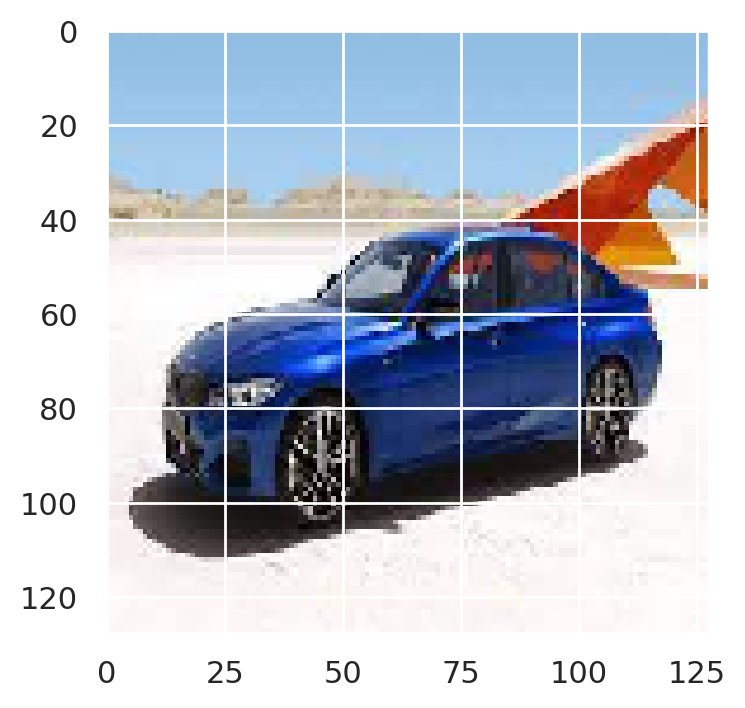

In [164]:
filename = '../input/customcarimages/bmw.jpg'
drowPredictedBBOnImage(filename,(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL),'image_array','rgb')